#**Analyzing New York City's For-Hire Vehicle Industry**

This section introduces the project, **"Analyzing New York City's For-Hire Vehicle Industry,"** focusing on Uber's role in shaping transportation dynamics. The title slide highlights the project's objectives, including market analysis, competition insights, and the impact of regulations on the NYC transportation landscape. The project is presented by team members **Bharath, Manogna, and Drashi**.


Dataset Link: dataset link: https://www.kaggle.com/datasets/shuhengmo/uber-nyc-forhire-vehicles-trip-data-2021

---
---


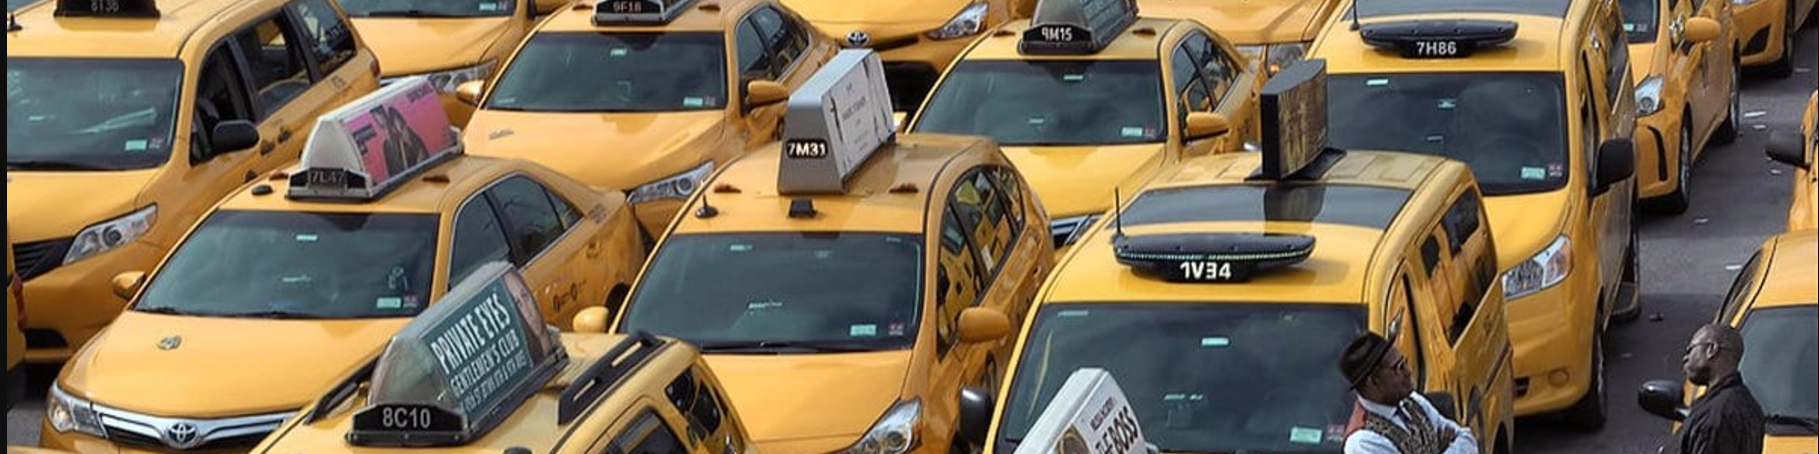

##**Installation**
This cell installs the necessary tools and libraries to set up the environment for analyzing the dataset. Specifically:

1. **PySpark**: Installs PySpark, a Python interface for Apache Spark, to process and analyze large datasets efficiently.
2. **Java**: Installs OpenJDK 11, as Spark requires Java for execution.
3. **GCS Connector**: Downloads the Google Cloud Storage (GCS) Connector to enable seamless interaction between Spark and GCS for accessing the dataset.



In [ ]:
# Install PySpark
!pip install pyspark

# Install Java (required for Spark)
!apt-get install openjdk-11-jdk-headless -y

# Download GCS Connector
!wget https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar -P /usr/lib/spark/jars/


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.25+9-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
--2024-12-05 21:39:45--  https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40713341 (39M) [application/java-archive]
Saving to: ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’

gcs-connector-hadoo 100%[===================>]  38.83M  14.0MB/s    in 2.8s    

2024-12-05 21:39:48 (14.0 MB/s) - ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’ saved [40713341/40713341]



--- ---




## **Spark Session Initialization**
This cell initializes a Spark session to perform data processing and analysis. The Spark session is configured with the following:

- **Application Name**: Set as `UberTripData_analysis`.
- **GCS Connector**: Configured to enable Spark to interact with Google Cloud Storage (GCS) using the downloaded connector.
- **Memory Settings**: Allocates 2 GB of memory each for the Spark executor and driver to handle dataset operations efficiently.

Once executed, it confirms the successful creation of the Spark session.


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("UberTripData_analysis") \
    .config("spark.jars", "/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print("Spark Session Created!")


Spark Session Created!


---


## **Authentication of the Colab environment with Google Cloud**


In [ ]:
# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

---


## **Loading Uber NYC For-Hire Vehicles Trip Data from Google Cloud Storage**

In this step, we define the path to the Google Cloud Storage (GCS) bucket where the Parquet files containing the Uber NYC for-hire vehicle trip data are stored. We then use Apache Spark to load the Parquet files into a Spark DataFrame for efficient processing and analysis. Finally, we print the schema of the DataFrame to understand the structure of the data and display a sample of the first 5 rows to inspect the contents.


In [ ]:
# Define the GCS bucket path
gcs_path = "gs://nyc-data-bucket-manogna/*.parquet"

# Load Parquet files into a Spark DataFrame
tripdata_spark = spark.read.parquet(gcs_path)

# Display the schema and sample rows
tripdata_spark.printSchema()
tripdata_spark.show(5)


root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_f

---

## **Data Cleaning and Trip Duration Calculation**

In this step, we perform two key operations on the dataset:

1. **Drop Null Values**: We remove any rows with null values using the `na.drop()` function to ensure that we only work with complete data.

2. **Calculate Trip Duration**: A new column, `trip_duration_minutes`, is added to the dataset by calculating the difference between the `dropoff_datetime` and `pickup_datetime` columns, converting the result from seconds to minutes.

Finally, we display the first 5 rows of the cleaned dataset to verify the changes.


In [ ]:
from pyspark.sql.functions import col, expr

# Drop rows with null values (if applicable)
tripdata_cleaned = tripdata_spark.na.drop()

# Add a column for trip duration in minutes
tripdata_cleaned = tripdata_cleaned.withColumn(
    "trip_duration_minutes",
    (expr("unix_timestamp(dropoff_datetime)") - expr("unix_timestamp(pickup_datetime)")) / 60
)

# Display cleaned data
tripdata_cleaned.show(5)


+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+---------------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|trip_duration_minutes|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+-

---

## **Top Pickup Locations**

In this step, we count the number of trips for each pickup location by grouping the dataset by the `PULocationID` column. The results are ordered in descending order to identify the most frequently used pickup locations.

We then display the top 10 pickup locations, based on the number of trips, to provide insights into the busiest areas for trip pickups.


In [ ]:
#5.1. Top Pickup Locations
# Count trips by pickup location
pickup_counts = tripdata_cleaned.groupBy("PULocationID").count().orderBy("count", ascending=False)

# Show top 10 pickup locations
pickup_counts.show(10)


+------------+-------+
|PULocationID|  count|
+------------+-------+
|          79|1451191|
|          61|1363346|
|         132|1291272|
|          76|1202635|
|         138|1193863|
|         231|1178872|
|         234|1107693|
|          37|1097010|
|         230|1058711|
|         161|1057137|
+------------+-------+
only showing top 10 rows



---

## **Average Trip Duration**

In this step, we calculate the average trip duration in minutes by using the `avg()` function on the `trip_duration_minutes` column. This provides insight into the typical length of an Uber trip in the dataset.

The result is displayed as a single value representing the average trip duration across all trips.


In [ ]:
#5.2. Average Trip Duration
# Calculate average trip duration
tripdata_cleaned.selectExpr("avg(trip_duration_minutes) as avg_trip_duration").show()


+------------------+
| avg_trip_duration|
+------------------+
|18.670038766851274|
+------------------+



---

## **Saving Cleaned Data to Google Cloud Storage**

In this step, we save the cleaned dataset back to Google Cloud Storage (GCS) in Parquet format. The data is saved to the specified `output_path`, which includes the bucket name (`nyc-data-bucket-manogna`) and the desired file name (`cleaned_tripdata.parquet`).

We ensure that if the file already exists in the destination, it will be


In [ ]:
# Save the cleaned data back to GCS, overwriting if the file already exists
output_path = "gs://nyc-data-bucket-manogna/cleaned_tripdata.parquet"
#Double-check if 'nyc-data-bucket-manogna' is the correct bucket name and 'cleaned_tripdata.parquet' is the desired directory.

#tripdata_cleaned.write.mode("overwrite").parquet(output_path)
print(f"Cleaned data saved to {output_path}")


Cleaned data saved to gs://nyc-data-bucket-manogna/cleaned_tripdata.parquet


---


##**Identifying Peak Usage Times for Uber NYC For-Hire Vehicles**
In this step, we analyze the peak usage times for Uber trips by extracting the hour and day of the week from the `pickup_datetime` column. We create new columns for `hour` and `day_of_week` to capture this information.

Next, we group the data by `hour` to identify the most popular times of day and by `day_of_week` to determine the days with the highest trip counts. The data is then converted to a Pandas DataFrame for easier visualization.

We generate two bar plots:
1. **Trips by Hour of the Day**: Shows the distribution of trips across different hours.
2. **Trips by Day of the Week**: Displays the trip frequency for each day of the week, where 1 represents Sunday and 7 represents Saturday.

These visualizations help in identifying peak hours and days for Uber trip activity.


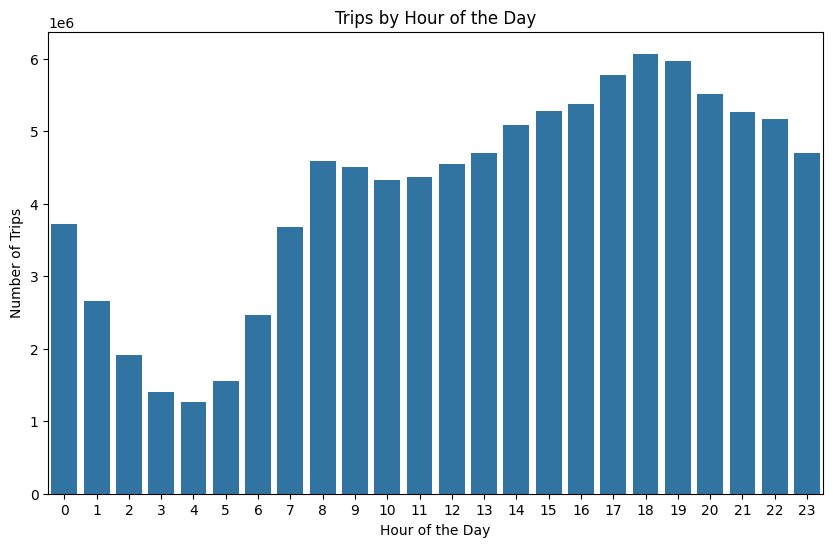

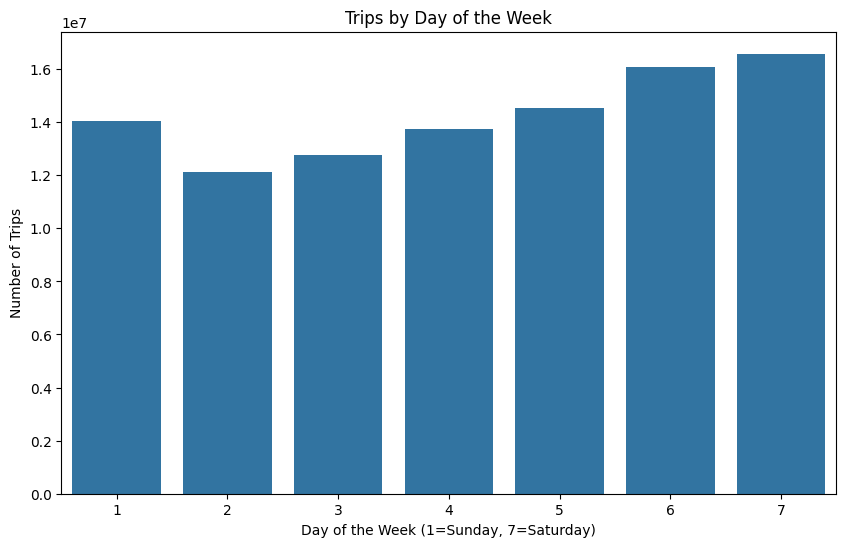

In [ ]:
from pyspark.sql.functions import hour, dayofweek
import matplotlib.pyplot as plt # Import matplotlib.pyplot before using plt
import seaborn as sns

# Add hour and day_of_week columns
tripdata_cleaned = tripdata_cleaned.withColumn("hour", hour("pickup_datetime"))
tripdata_cleaned = tripdata_cleaned.withColumn("day_of_week", dayofweek("pickup_datetime"))

# Group by hour to find peak hours
peak_hours = tripdata_cleaned.groupBy("hour").count().orderBy("count", ascending=False)

# Group by day of the week to find peak days
peak_days = tripdata_cleaned.groupBy("day_of_week").count().orderBy("count", ascending=False)

# Convert to Pandas for visualization
peak_hours_pd = peak_hours.toPandas()
peak_days_pd = peak_days.toPandas()


# Plot Peak Hours
plt.figure(figsize=(10, 6))
sns.barplot(data=peak_hours_pd, x="hour", y="count")
plt.title("Trips by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips")
plt.show()

# Plot Peak Days
plt.figure(figsize=(10, 6))
sns.barplot(data=peak_days_pd, x="day_of_week", y="count")
plt.title("Trips by Day of the Week")
plt.xlabel("Day of the Week (1=Sunday, 7=Saturday)")
plt.ylabel("Number of Trips")
plt.show()


---


##**Analyzing Pickup and Dropoff Locations**

In this step, we analyze the most frequently used pickup and dropoff locations for Uber trips by grouping the data based on `PULocationID` (pickup location) and `DOLocationID` (dropoff location). We then count the number of trips for each location and select the top 10 most popular pickup and dropoff locations.

The results are converted to Pandas DataFrames for easier visualization.

We create two bar plots:
1. **Top 10 Pickup Locations**: Displays the 10 pickup locations with the highest number of trips.
2. **Top 10 Dropoff Locations**: Shows the 10 dropoff locations with the most trips.

These visualizations help identify high-demand areas, which can provide insights into trip distribution across the city.


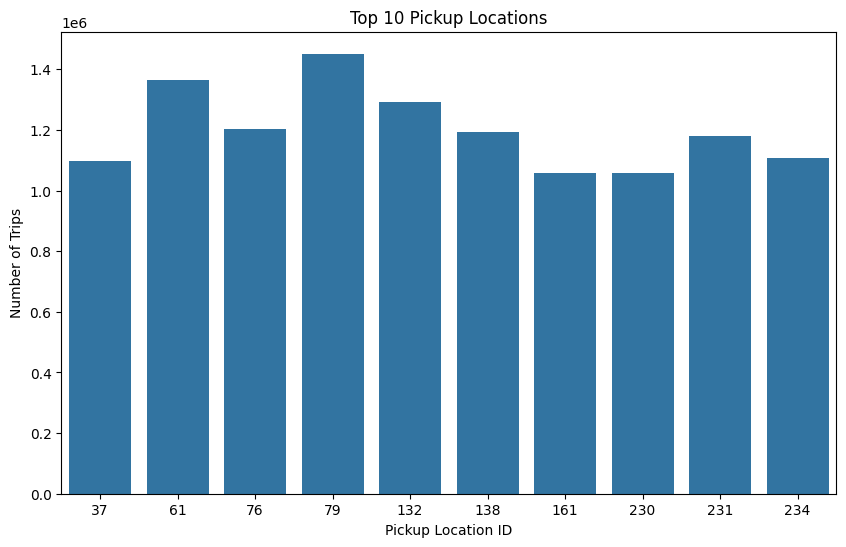

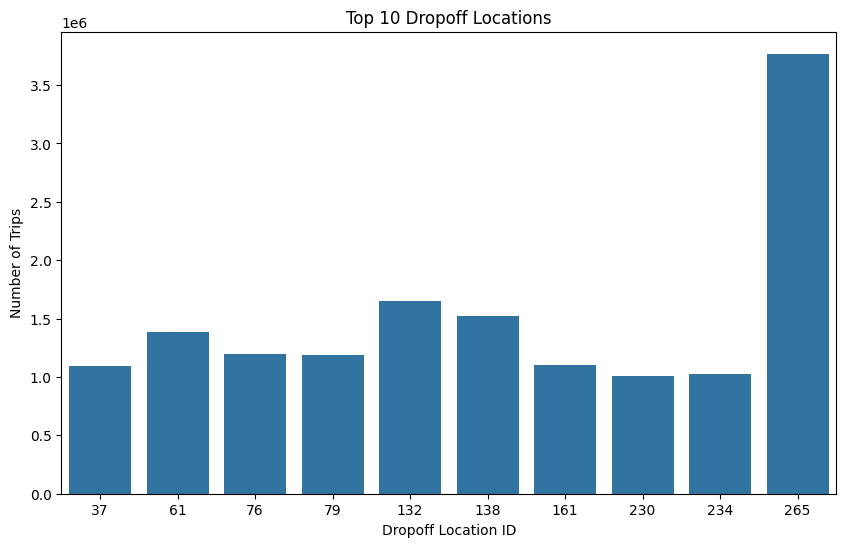

In [ ]:
# Group by pickup and dropoff locations
top_pickup_locations = tripdata_cleaned.groupBy("PULocationID").count().orderBy("count", ascending=False).limit(10)
top_dropoff_locations = tripdata_cleaned.groupBy("DOLocationID").count().orderBy("count", ascending=False).limit(10)

# Convert to Pandas
top_pickup_locations_pd = top_pickup_locations.toPandas()
top_dropoff_locations_pd = top_dropoff_locations.toPandas()

# Plot Pickup Locations
plt.figure(figsize=(10, 6))
sns.barplot(data=top_pickup_locations_pd, x="PULocationID", y="count")
plt.title("Top 10 Pickup Locations")
plt.xlabel("Pickup Location ID")
plt.ylabel("Number of Trips")
plt.show()

# Plot Dropoff Locations
plt.figure(figsize=(10, 6))
sns.barplot(data=top_dropoff_locations_pd, x="DOLocationID", y="count")
plt.title("Top 10 Dropoff Locations")
plt.xlabel("Dropoff Location ID")
plt.ylabel("Number of Trips")
plt.show()


---


## **Analyzing Average Trip Duration by Month**

In this step, we calculate the average trip duration for each month by extracting the `month` from the `pickup_datetime` column. We group the data by month and calculate the average trip duration in minutes for each month.

The result is then converted to a Pandas DataFrame for easier visualization.

We create a line plot to visualize the average trip duration across different months. The plot helps to identify any seasonal patterns or trends in trip durations over the year.


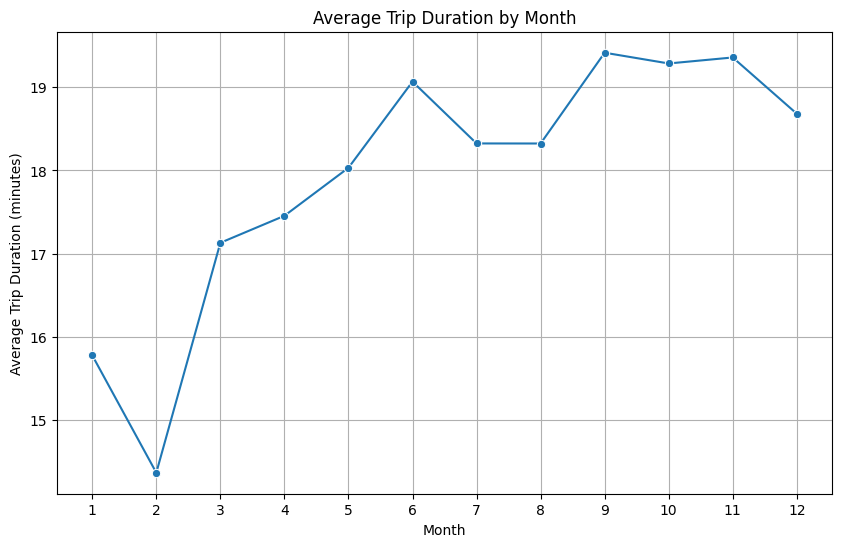

In [ ]:
# Group by month to find average trip duration
from pyspark.sql.functions import month, avg

tripdata_cleaned = tripdata_cleaned.withColumn("month", month("pickup_datetime"))
avg_trip_duration = tripdata_cleaned.groupBy("month").agg(avg("trip_duration_minutes").alias("avg_trip_duration"))

# Convert to Pandas
avg_trip_duration_pd = avg_trip_duration.toPandas()

# Plot Average Trip Duration
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_trip_duration_pd, x="month", y="avg_trip_duration", marker="o")
plt.title("Average Trip Duration by Month")
plt.xlabel("Month")
plt.ylabel("Average Trip Duration (minutes)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()


---

## **Analyzing Driver Earnings**

In this step, we analyze the distribution of driver earnings by grouping the dataset by the `driver_pay` column and counting the number of occurrences for each earnings value. The data is then sorted in descending order to identify the most frequent earnings values.

We convert the results into a Pandas DataFrame for easier visualization.

A histogram is created to display the distribution of driver earnings. The plot also includes a kernel density estimate (KDE) to visualize the probability density of earnings. This analysis provides insights into the range and frequency of earnings among drivers.



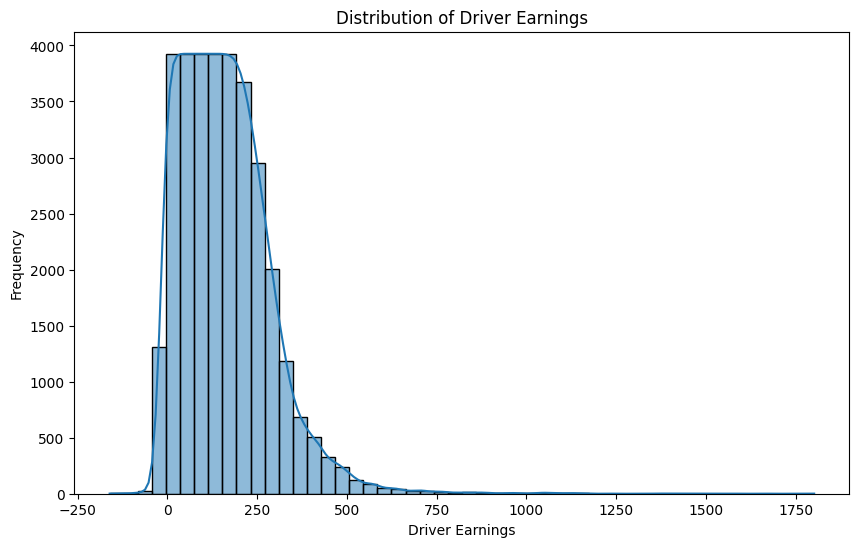

In [ ]:
# Analyze driver earnings
driver_earnings = tripdata_cleaned.groupBy("driver_pay").count().orderBy("driver_pay", ascending=False)

# Convert to Pandas
driver_earnings_pd = driver_earnings.toPandas()

# Plot Driver Earnings
plt.figure(figsize=(10, 6))
sns.histplot(data=driver_earnings_pd, x="driver_pay", bins=50, kde=True)
plt.title("Distribution of Driver Earnings")
plt.xlabel("Driver Earnings")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Show the column names in the DataFrame
tripdata_cleaned.columns


['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'trip_duration_minutes',
 'hour',
 'day_of_week',
 'month',
 'taxi_type']

---
## **Sampling Data and Analyzing Trip Time Distribution**

To prevent memory issues when working with large datasets, we first sample a subset of the data. In this case, we randomly sample 1% of the `trip_time` column from the cleaned dataset and convert it to a Pandas DataFrame.

We then create a histogram to visualize the distribution of trip times in minutes. The plot includes a kernel density estimate (KDE) to show the probability density of trip times. This analysis helps in understanding the overall distribution of trip durations in the dataset.


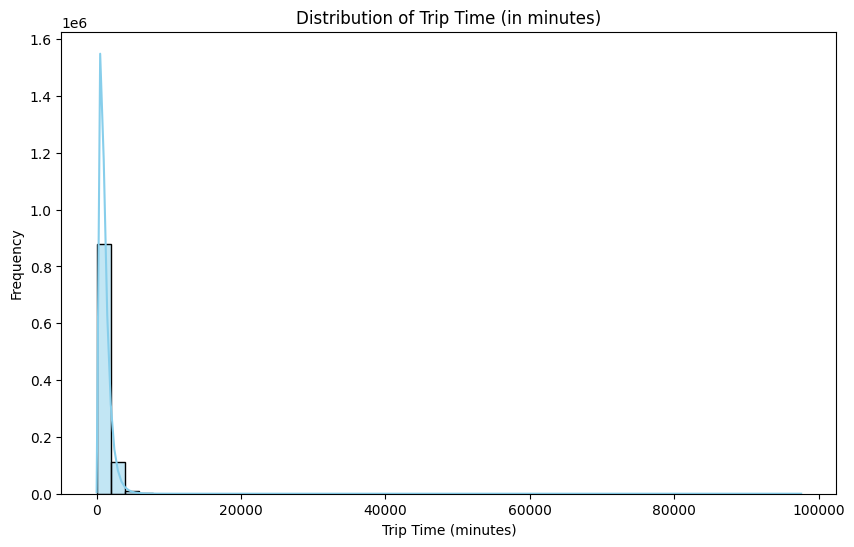

In [ ]:
# Sample a subset of the data to avoid memory issues
trip_time_sample = tripdata_cleaned.select("trip_time").sample(fraction=0.01).toPandas()

# 1. Distribution of Trip Time
plt.figure(figsize=(10, 6))
sns.histplot(trip_time_sample['trip_time'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Trip Time (in minutes)")
plt.xlabel("Trip Time (minutes)")
plt.ylabel("Frequency")
plt.show()


---

## **Analyzing Tips by Trip Distance Range**

In this step, we first convert the `tips` column from cents to dollars by dividing the values by 100.

Next, we categorize the trips into different distance ranges using predefined bins:
- 0-2 miles
- 2-5 miles
- 5-10 miles
- 10+ miles

We create a new column, `trip_distance_bin`, that assigns each trip to the appropriate distance range.

A boxplot is then generated to visualize the distribution of tips within each trip distance range. This helps identify how trip distance may influence tipping behavior, showing the spread and potential outliers for tips in different distance categories.


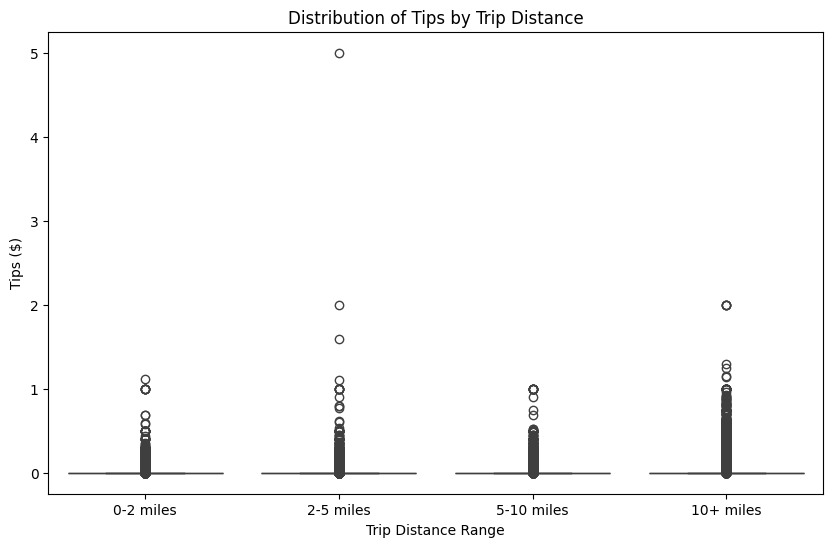

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming the 'tips' column is in cents, convert it to dollars by dividing by 100
tripdata_cleaned['tips'] = tripdata_cleaned['tips'] / 100

# Create bins for trip distance ranges
bins = [0, 2, 5, 10, float('inf')]  # Define the bin edges
labels = ["0-2 miles", "2-5 miles", "5-10 miles", "10+ miles"]  # Labels for the bins

# Add a new column for the trip distance range
tripdata_cleaned['trip_distance_bin'] = pd.cut(tripdata_cleaned['trip_miles'], bins=bins, labels=labels, right=False)

# Plot Boxplot of Tips by Trip Distance Range
plt.figure(figsize=(10, 6))
sns.boxplot(data=tripdata_cleaned, x="trip_distance_bin", y="tips")
plt.title("Distribution of Tips by Trip Distance")
plt.xlabel("Trip Distance Range")
plt.ylabel("Tips ($)")  # Now in dollars
plt.show()


---

## **Analyzing Average Base Fare vs. Tips**

In this step, we categorize the `base_passenger_fare` values into more granular ranges using predefined bins. These bins represent various fare ranges, such as 0-5 dollars, 5-10 dollars, and so on.

We create a new column, `fare_bin`, which assigns each trip to one of these fare ranges.

We then group the data by the `fare_bin` column and calculate the average base fare and the average tips for each fare range.

A line plot is generated to show the relationship between the average base fare and the average tips across different fare ranges. This plot helps to analyze whether higher fares are associated with higher tips.

To better visualize the data, the y-axis for tips is set to a logarithmic scale, which can help in highlighting trends, especially for smaller tip amounts.


<ipython-input-36-66db5a29b18a>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_tips_avg = tripdata_cleaned.groupby('fare_bin').agg(


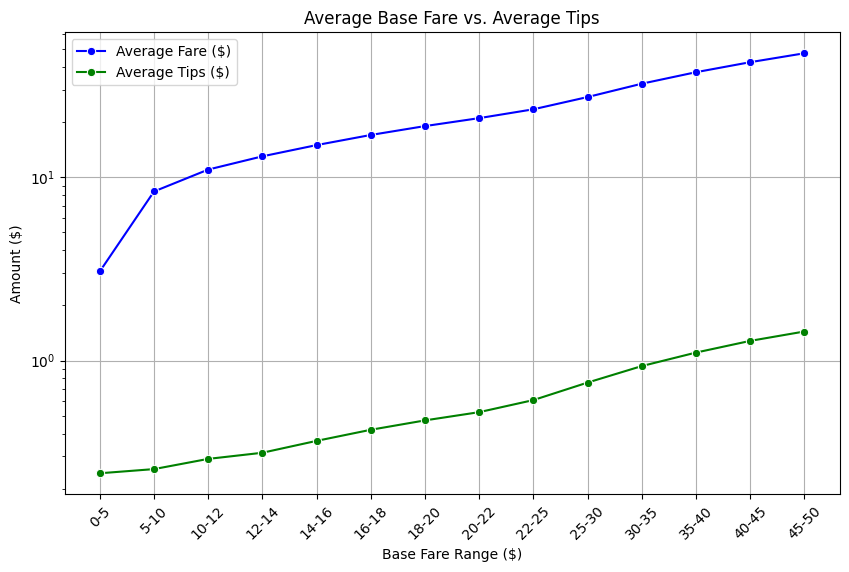

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create more granular bins for base fare ranges
fare_bins = [0, 5, 10, 12, 14, 16, 18, 20, 22, 25, 30, 35, 40, 45, 50]
fare_labels = ['0-5', '5-10', '10-12', '12-14', '14-16', '16-18', '18-20', '20-22', '22-25', '25-30', '30-35', '35-40', '40-45', '45-50']

# Bin the base fare values
tripdata_cleaned['fare_bin'] = pd.cut(tripdata_cleaned['base_passenger_fare'], bins=fare_bins, labels=fare_labels)

# Group by fare_bin and calculate the mean of base_fare and tips for each bin
fare_tips_avg = tripdata_cleaned.groupby('fare_bin').agg(
    avg_fare=('base_passenger_fare', 'mean'),
    avg_tips=('tips', 'mean')
).reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Line plot for Base Fare vs. Tips
sns.lineplot(data=fare_tips_avg, x='fare_bin', y='avg_fare', marker='o', label='Average Fare ($)', color='blue')
sns.lineplot(data=fare_tips_avg, x='fare_bin', y='avg_tips', marker='o', label='Average Tips ($)', color='green')

# Title and Labels
plt.title("Average Base Fare vs. Average Tips")
plt.xlabel("Base Fare Range ($)")
plt.ylabel("Amount ($)")

# Set the y-axis for tips to a logarithmic scale for better visualization
plt.yscale('log')

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


---


## **Distribution of Trip Distances and Trip Times**

In this step, we visualize the distribution of trip distances and trip times in a combined figure with two subplots.

1. **Trip Distance Distribution**: A histogram and kernel density estimate (KDE) are plotted for the `trip_miles` column, with a filter applied to remove outliers (trips with distance greater than 50 miles). The x-axis is limited to 50 miles to focus on more typical trip distances.

2. **Trip Time Distribution**: A histogram and KDE are also plotted for the `trip_time` column, showing the distribution of trip durations.

By displaying both visualizations side by side, we can easily compare the distribution of trip distances and trip times, helping us understand the relationship between the two and identify trends in the dataset.



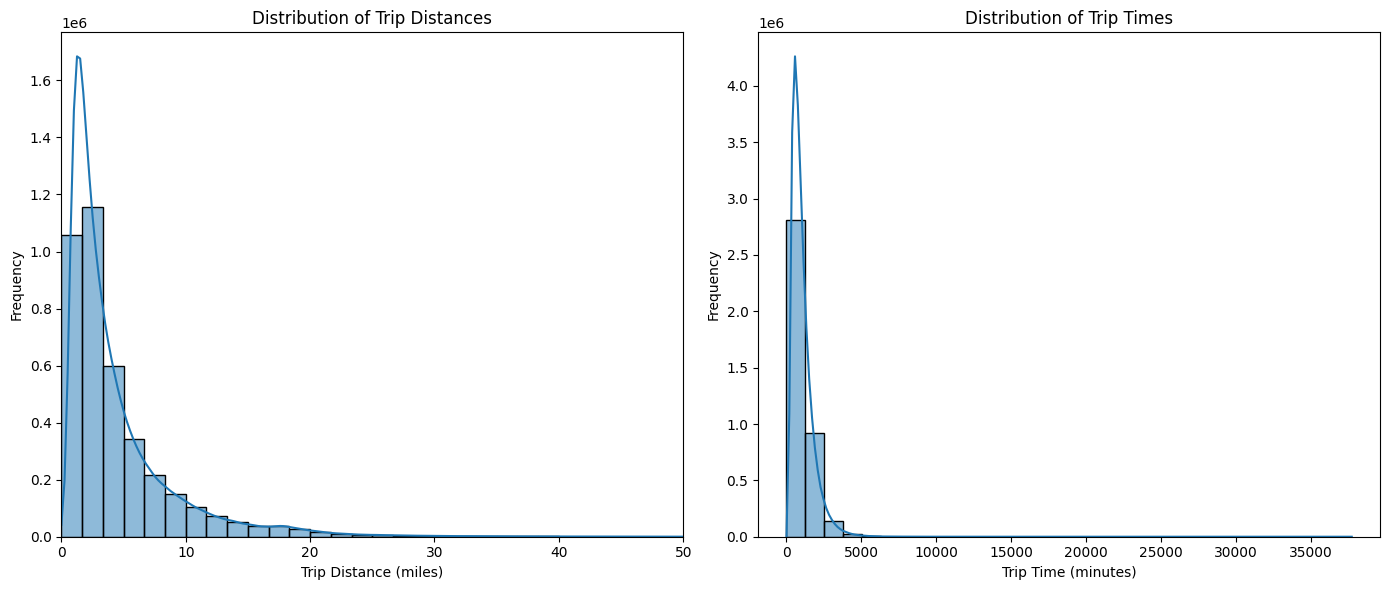

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Trip Distances and Trip Times (combined in one figure)

# Create subplots (2 rows, 1 column)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Optional: Remove outliers for Trip Distances (e.g., remove trips with distance > 50 miles)
filtered_data = tripdata_cleaned[tripdata_cleaned['trip_miles'] <= 50]

# Plot the histogram and KDE for Trip Distances
sns.histplot(filtered_data['trip_miles'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Trip Distances')
axes[0].set_xlabel('Trip Distance (miles)')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 50)  # Set x-axis limit for distances

# Plot the histogram and KDE for Trip Times
sns.histplot(tripdata_cleaned['trip_time'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Trip Times')
axes[1].set_xlabel('Trip Time (minutes)')
axes[1].set_ylabel('Frequency')

# Adjust the layout to make sure the titles/labels are not overlapping
plt.tight_layout()

# Show the plot
plt.show()


---

## **Trips by Pickup Location (Top Locations)**

In this step, we visualize the proportion of trips from the top 5 pickup locations using a pie chart. The goal is to identify the most popular pickup points and highlight high-demand areas.

- We first calculate the frequency of trips for each pickup location (`PULocationID`) and extract the top 5 locations based on the number of trips.
- A pie chart is then created to show the percentage of total trips associated with each of these top pickup locations. The slices represent each of the top 5 pickup locations, with the percentage indicating the proportion of trips relative to the total.

This visualization helps us understand the distribution of trips across different pickup locations, making it easy to identify dominant areas and any imbalances in trip volume across locations.


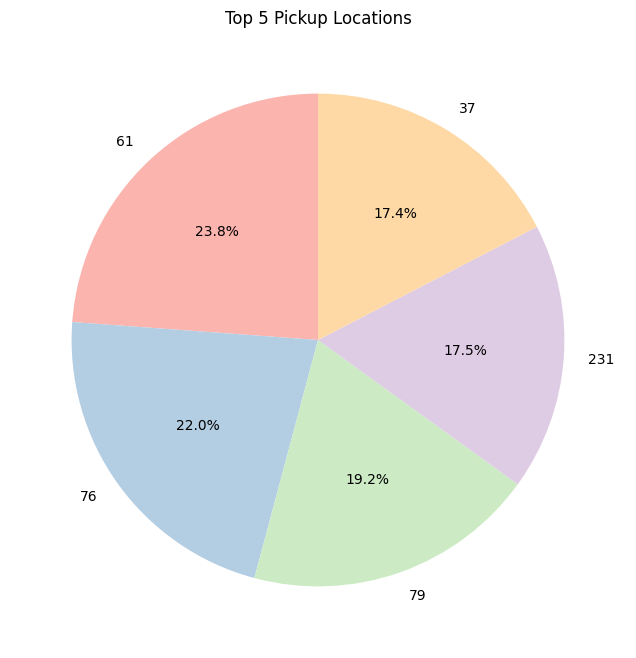

In [ ]:
# Trips by Pickup Location (Top Locations)
# Goal: Show the proportion of trips from the top pickup locations.
# Why: This will highlight the most popular pickup points, helping to identify high-demand areas.

top_pickup_locations = tripdata_cleaned['PULocationID'].value_counts().head(5)
plt.figure(figsize=(8, 8))
top_pickup_locations.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Pastel1", len(top_pickup_locations)))
plt.title('Top 5 Pickup Locations')
plt.ylabel('')
plt.show()



---
## **Pie Chart for Congestion Surcharge Flag**

In this step, we visualize the distribution of trips with and without a congestion surcharge using a pie chart. The goal is to understand the proportion of trips that incur this additional fee.

- The `congestion_surcharge` column is used to determine whether a surcharge was applied to the trip.
- The pie chart shows the percentage of trips that had a congestion surcharge versus those that did not.

A **congestion surcharge** is an additional fee charged during trips that occur in areas with heavy traffic congestion. This fee is typically implemented in busy urban areas to:
- Reduce traffic congestion,
- Improve air quality,
- Encourage the use of public transport or alternative travel options during peak hours.

The chart provides insights into how frequently the surcharge is applied and its potential impact on trip pricing.


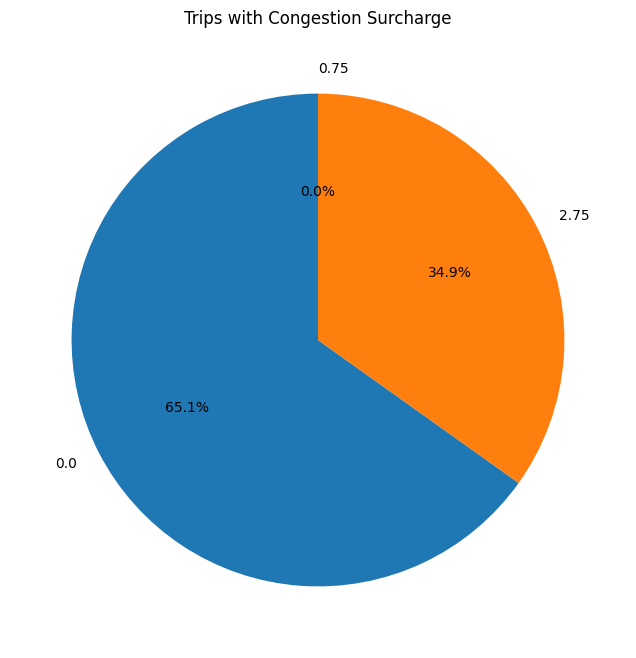

In [ ]:
# Pie chart for Congestion Surcharge Flag
congestion_surcharge_counts = tripdata_cleaned['congestion_surcharge'].value_counts()
congestion_surcharge_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=90)
plt.title('Trips with Congestion Surcharge')
plt.ylabel('')
plt.show()
